## Evolutionary optimization with Jax

Here we will have fun experimenting with implementing a very simple evolutionary optimization program using Jax that will as a result be able to benefit from acceleration (as well as I guess be differentiated? ;P).


#### Setup and generating sequences

In [5]:
import jax.numpy as jnp
from jax import random, jit, vmap
from matplotlib import pyplot
import numpy as np
key = random.PRNGKey(1234)

In [6]:

def random_sequence_b(length):
    return random.randint(minval=0, maxval=4, shape=(length,), key=key)


In [7]:

def generate_population_a(key, length=10, pop_size=10):
    return random.randint(minval=0, maxval=4, shape=(pop_size,length), key=key)


In [8]:
population = generate_population_a(key=key)
population

DeviceArray([[2, 3, 3, 0, 3, 0, 3, 0, 3, 1],
             [3, 3, 3, 2, 0, 2, 2, 2, 3, 3],
             [3, 2, 0, 0, 2, 0, 3, 2, 3, 2],
             [3, 0, 2, 3, 3, 3, 0, 0, 2, 0],
             [2, 1, 2, 1, 1, 2, 2, 0, 0, 1],
             [0, 0, 0, 1, 1, 2, 3, 2, 0, 2],
             [1, 1, 0, 1, 2, 1, 2, 0, 1, 2],
             [3, 2, 2, 2, 1, 1, 2, 2, 3, 0],
             [0, 1, 0, 3, 0, 1, 0, 3, 1, 0],
             [2, 3, 1, 3, 2, 2, 1, 3, 3, 1]], dtype=int32)

In [69]:

def generate_population(key, length=10, pop_size=10):
    return random.randint(minval=0, maxval=4, shape=(pop_size,length), key=key)

def fitness_29(v):
    return 1 - jnp.abs(jnp.mean(v) - 2.9)/2.9

@jit
def batched_fitness_29(population):
    return vmap(fitness_29)(population)

def mutate_population(key, population, p_mutation=[0.85,0.05,0.05,0.05,0.05]):
    mutation = random.choice(
        key,
        a=jnp.array([0,1,2,3,4]),
        shape=population.shape,
        p=jnp.array(p_mutation))
    return jnp.mod(population + mutation, 4)

def resample_population(key, population, fitnesses):
    retain_members = random.choice(
        key=key,
        a=jnp.array([i for i in range(population.shape[0])]),
        shape=(population.shape[0],),
        p=fitnesses, replace=True)
    return jnp.stack([population[i] for i in retain_members])


In [70]:

def evolve_with_mutation(fitness_fn,
                         keep_full_population_history=False,
                         num_generations=100, pop_size=100,
                         genome_length=10, report_every=10,
                         p_mutation=[0.96,0.01,0.01,0.01,0.01]):

    key = random.PRNGKey(1)
    p_mutation_base = p_mutation
    base_mutation_rate = p_mutation_base[1] # assume it's the same for all four letters of alphabet

    fitness_history = np.zeros(shape=(num_generations,))
    
    population_history = None
    if keep_full_population_history:
        population_history = np.zeros(shape=(num_generations, pop_size, genome_length))
    
    population = generate_population(
        key=key,
        length=genome_length,
        pop_size=pop_size)       

    for i in range(num_generations):

        key, _ = random.split(key)
        population = mutate_population(
            key, population,
            p_mutation=p_mutation
        )

        if keep_full_population_history:
            # Could keep track at any point in this loop, making sure
            # at least fitness_history and population_history are in
            # sync.
            population_history[i] = population

        fitnesses = fitness_fn(population)
        fitness_history[i] = jnp.mean(fitnesses)
        max_fitness = jnp.max(fitnesses)
        min_fitness = jnp.min(fitnesses)
        epsilon = 0.000000000000001
        norm_fitnesses = (fitnesses - min_fitness + epsilon)/(max_fitness - min_fitness + epsilon)

        if i % report_every == 0.0:
            print("Current average fitness: %s" % jnp.mean(fitnesses))

        mutation_rate = base_mutation_rate*(1-jnp.mean(norm_fitnesses)/2)
        non_mutation_rate = 1-4*mutation_rate
        p_mutation = [non_mutation_rate, mutation_rate, mutation_rate, mutation_rate, mutation_rate]

        key, _ = random.split(key)
        population = resample_population(
            key=key,
            population=population,
            fitnesses=norm_fitnesses)
        
    return fitness_history, population_history, population


In [71]:

hist = evolve_with_mutation(fitness_fn=batched_fitness_29,
                            num_generations=50, pop_size=100, genome_length=10,
                            p_mutation=[0.996,0.001,0.001,0.001,0.001],
                            keep_full_population_history=True)


Current average fitness: 0.5296552
Current average fitness: 0.8934482
Current average fitness: 0.89655167
Current average fitness: 0.92896545
Current average fitness: 1.0


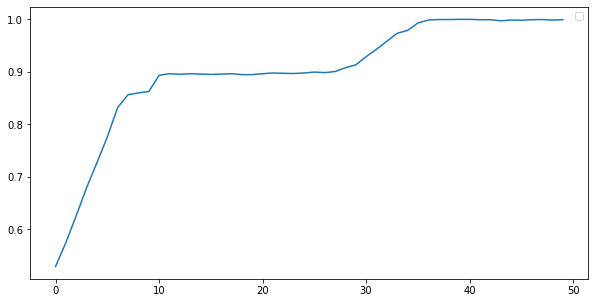

In [72]:

f = pyplot.figure() 
f.set_figwidth(10) 
f.set_figheight(5)
pyplot.plot(hist[0])
pyplot.legend()
pyplot.show()


In [65]:

jnp.sd(hist[1][0])


AttributeError: module 'jax.numpy' has no attribute 'sd'

### Generalize to different-sized alphabets

In [35]:
import jax.numpy as jnp
jnp.array(range(4))

DeviceArray([0, 1, 2, 3], dtype=int32)

In [1]:

import jax.numpy as jnp
from jax import random, jit, vmap
from matplotlib import pyplot
import numpy as np
key = random.PRNGKey(1234)

def generate_population(key, length=10, pop_size=10):
    return random.randint(minval=0, maxval=4, shape=(pop_size,length), key=key)

def fitness_mean_value_target(v, target_value=1.0):
    return 1 - jnp.abs(jnp.mean(v) - target_value)/target_value

@jit
def batched_fitness_mean_value_target(population):
    return vmap(fitness_mean_value_target)(population)

def mutate_population(key, population, mutation_rate=0.15,
                      alphabet_size=4):

    individual_p_mutation = mutation_rate/alphabet_size
    # Lazily double-counts self-transitions as a type of mutation
    # in the interest of prototyping
    p_no_mutation = (1 - mutation_rate)
    mutation_probs = [
        individual_p_mutation for _ in range(alphabet_size)
    ]
    mutation_probs = [p_no_mutation] + mutation_probs

    mutation = random.choice(
        key,
        a=jnp.array(range(alphabet_size + 1)),
        shape=population.shape,
        p=jnp.array(mutation_probs))

    return jnp.mod(population + mutation, alphabet_size)

def resample_population(key, population, fitnesses):
    retain_members = random.choice(
        key=key,
        a=jnp.array([i for i in range(population.shape[0])]),
        shape=(population.shape[0],),
        p=fitnesses, replace=True)
    return jnp.stack([population[i] for i in retain_members])

def evolve_with_mutation(key,
                         fitness_fn,
                         keep_full_population_history=False,
                         num_generations=100, pop_size=100,
                         genome_length=10, report_every=10,
                         mutation_rate=0.15,
                         alphabet_size=4):

    base_mutation_rate = mutation_rate

    fitness_history = np.zeros(shape=(num_generations,))
    
    population_history = None
    if keep_full_population_history:
        population_history = np.zeros(shape=(num_generations, pop_size, genome_length))
    
    population = generate_population(
        key=key,
        length=genome_length,
        pop_size=pop_size)       

    for i in range(num_generations):

        if keep_full_population_history:
            # Could keep track at any point in this loop, making sure
            # at least fitness_history and population_history are in
            # sync.
            population_history[i] = population

        fitnesses = fitness_fn(population)
        fitness_history[i] = jnp.mean(fitnesses)
        max_fitness = jnp.max(fitnesses)
        min_fitness = jnp.min(fitnesses)
        epsilon = 0.000000000000001
        norm_fitnesses = (fitnesses - min_fitness + epsilon)/(max_fitness - min_fitness + epsilon)

        if i % report_every == 0.0:
            print("Current average fitness: %s" % jnp.mean(fitnesses))

        key, _ = random.split(key)
        population = resample_population(
            key=key,
            population=population,
            fitnesses=norm_fitnesses)

        mutation_rate = base_mutation_rate*(1-jnp.mean(norm_fitnesses)/2)

        key, _ = random.split(key)
        population = mutate_population(
            key, population,
            mutation_rate=mutation_rate
        )

    return fitness_history, population_history, population


In [2]:

hist = evolve_with_mutation(fitness_fn=batched_fitness_mean_value_target,
                            num_generations=50, pop_size=500, genome_length=100,
                            mutation_rate=0.15, alphabet_size=3,
                            keep_full_population_history=True,
                            key=random.PRNGKey(1))


Current average fitness: 0.50531995
Current average fitness: 0.70878005
Current average fitness: 0.74928004
Current average fitness: 0.75138
Current average fitness: 0.73786014


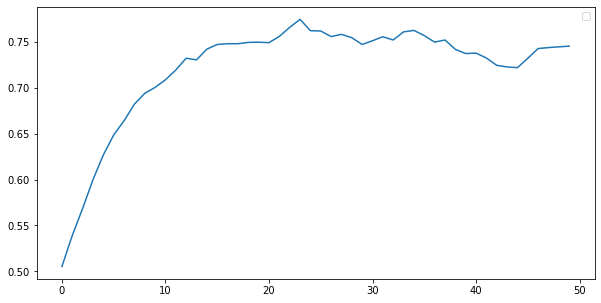

In [3]:

f = pyplot.figure()
f.set_figwidth(10) 
f.set_figheight(5)
pyplot.plot(hist[0])
pyplot.legend()
pyplot.show()


In [4]:
hist[2]

DeviceArray([[0, 3, 0, ..., 2, 0, 0],
             [2, 0, 2, ..., 1, 1, 0],
             [0, 0, 2, ..., 1, 0, 1],
             ...,
             [2, 1, 0, ..., 0, 2, 0],
             [0, 2, 3, ..., 3, 1, 0],
             [3, 0, 3, ..., 3, 0, 0]], dtype=int32)